In [130]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [254]:
from etna.models import (CatBoostModelMultiSegment, NaiveModel, MovingAverageModel, SeasonalMovingAverageModel,
                         SARIMAXModel, HoltWintersModel, ProphetModel, ElasticMultiSegmentModel, ElasticPerSegmentModel,
                         CatBoostModelPerSegment)

from etna.datasets import TSDataset

from etna.analysis import (plot_forecast, plot_periodogram, plot_anomalies, plot_anomalies_interactive, 
                           plot_imputation, plot_trend, plot_feature_relevance, ModelRelevanceTable)

from etna.analysis.plotters import plot_backtest

from etna.transforms import (MeanTransform, MeanSegmentEncoderTransform, SegmentEncoderTransform, HolidayTransform,
                             DateFlagsTransform, TrendTransform, FourierTransform, LogTransform, LinearTrendTransform,
                             BinsegTrendTransform, TheilSenTrendTransform, MedianOutliersTransform, DensityOutliersTransform,
                             TimeSeriesImputerTransform, StandardScalerTransform, MinMaxScalerTransform, RobustScalerTransform,
                             MaxAbsScalerTransform, LagTransform)

from etna.analysis.outliers import (get_anomalies_median, get_anomalies_density, get_anomalies_hist)

from etna.metrics import MAE, MSE, SMAPE, MAPE, RMSE
from etna.pipeline import Pipeline

In [382]:
def read_ts(path, date_column, target_column="Sales", segm_column="Store", freq="D", melt_df=False,
            sample=3, fillna=True, **kw):
    df = pd.read_csv(path, parse_dates=[date_column], **kw).sort_values(date_column)
    
    if sample > df.shape[1]:
        sample = df.shape[1]
        
    df = df.rename(columns={date_column: "timestamp", target_column: "target", segm_column: "segment"})
    df = df.loc[df["segment"].isin(list(range(sample+1))), ["timestamp", "segment", "target"]]
    df = df.replace(0, np.nan)
    if fillna:
        df = df.fillna(method="ffill").dropna()
    
    if not melt_df:
        df = df.melt(id_vars="timestamp", var_name="segment", value_name="target")
        
    df = TSDataset.to_dataset(df)
    ts = TSDataset(df, freq=freq)
    
    return ts

In [271]:
ts = read_ts("Desktop/times/train.csv", "Date", usecols=["Sales", "Store", "Date"], low_memory=False, melt_df=True)

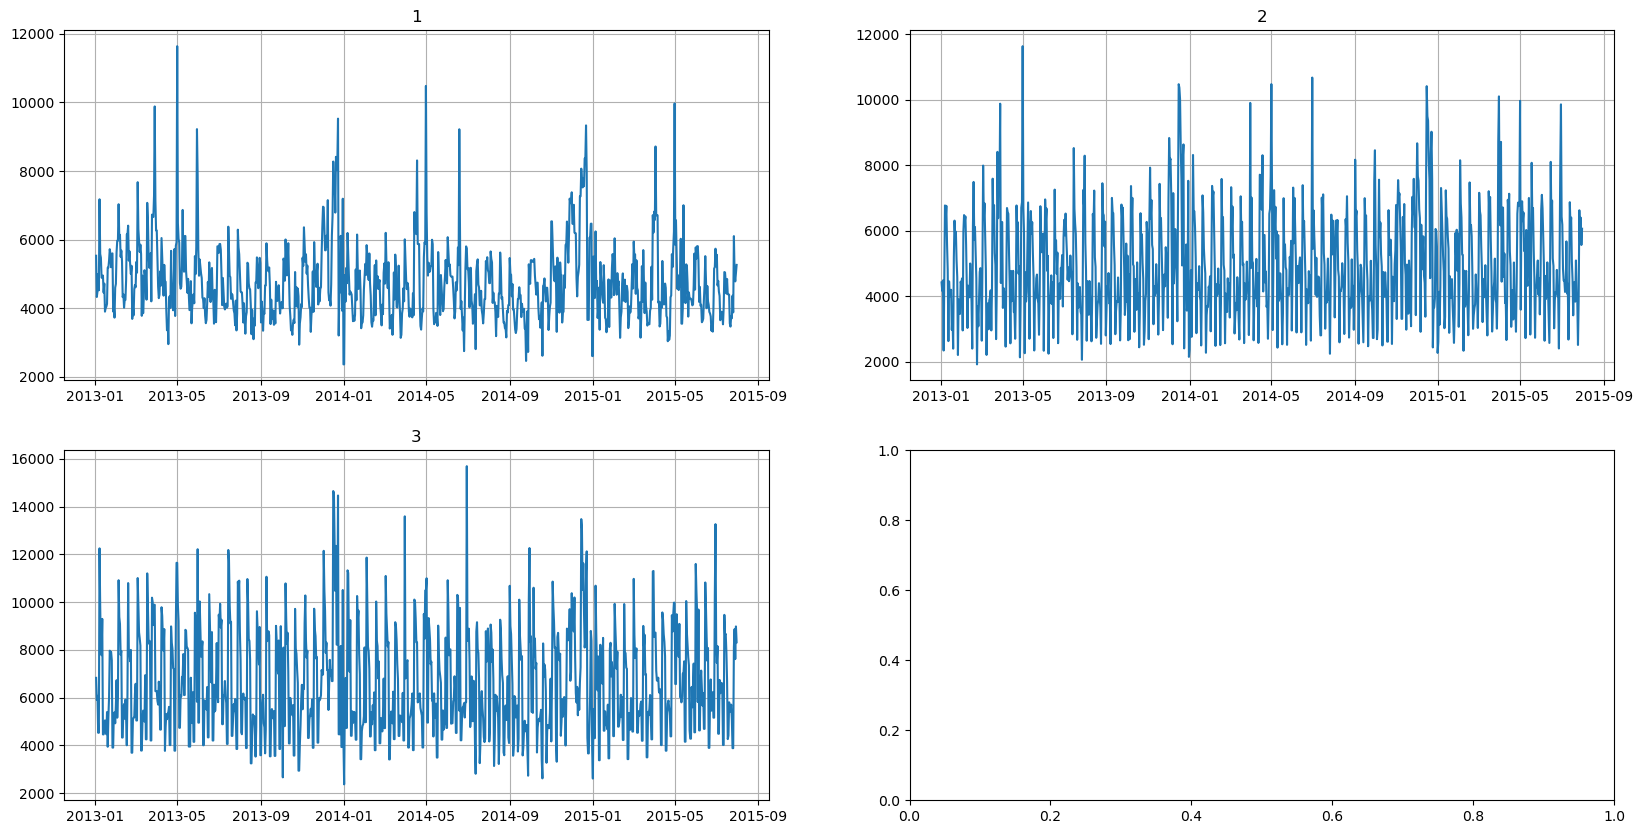

In [58]:
ts.plot()

In [59]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
1,2013-01-02,2015-07-31,941,0,3,0,0,0,D
2,2013-01-02,2015-07-31,941,0,3,0,0,0,D
3,2013-01-02,2015-07-31,941,0,3,0,0,0,D


In [282]:
horizon = 10

train_ts, test_ts = ts.train_test_split(train_start='2013-01-02', 
                                        train_end='2015-07-20',
                                        test_size=horizon)

In [80]:
model = NaiveModel(lag=6)
model.fit(train_ts)

NaiveModel(lag = 6, )

In [88]:
future_ts = train_ts.make_future(future_steps=horizon, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=horizon)

In [82]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'3': 26.85854914736802, '1': 16.071373865560894, '2': 23.75868852426266}

In [83]:
rmse = RMSE()
rmse(y_true=test_ts, y_pred=forecast_ts)

{'3': 2134.461852552067, '1': 826.2063301621454, '2': 1394.779301538419}

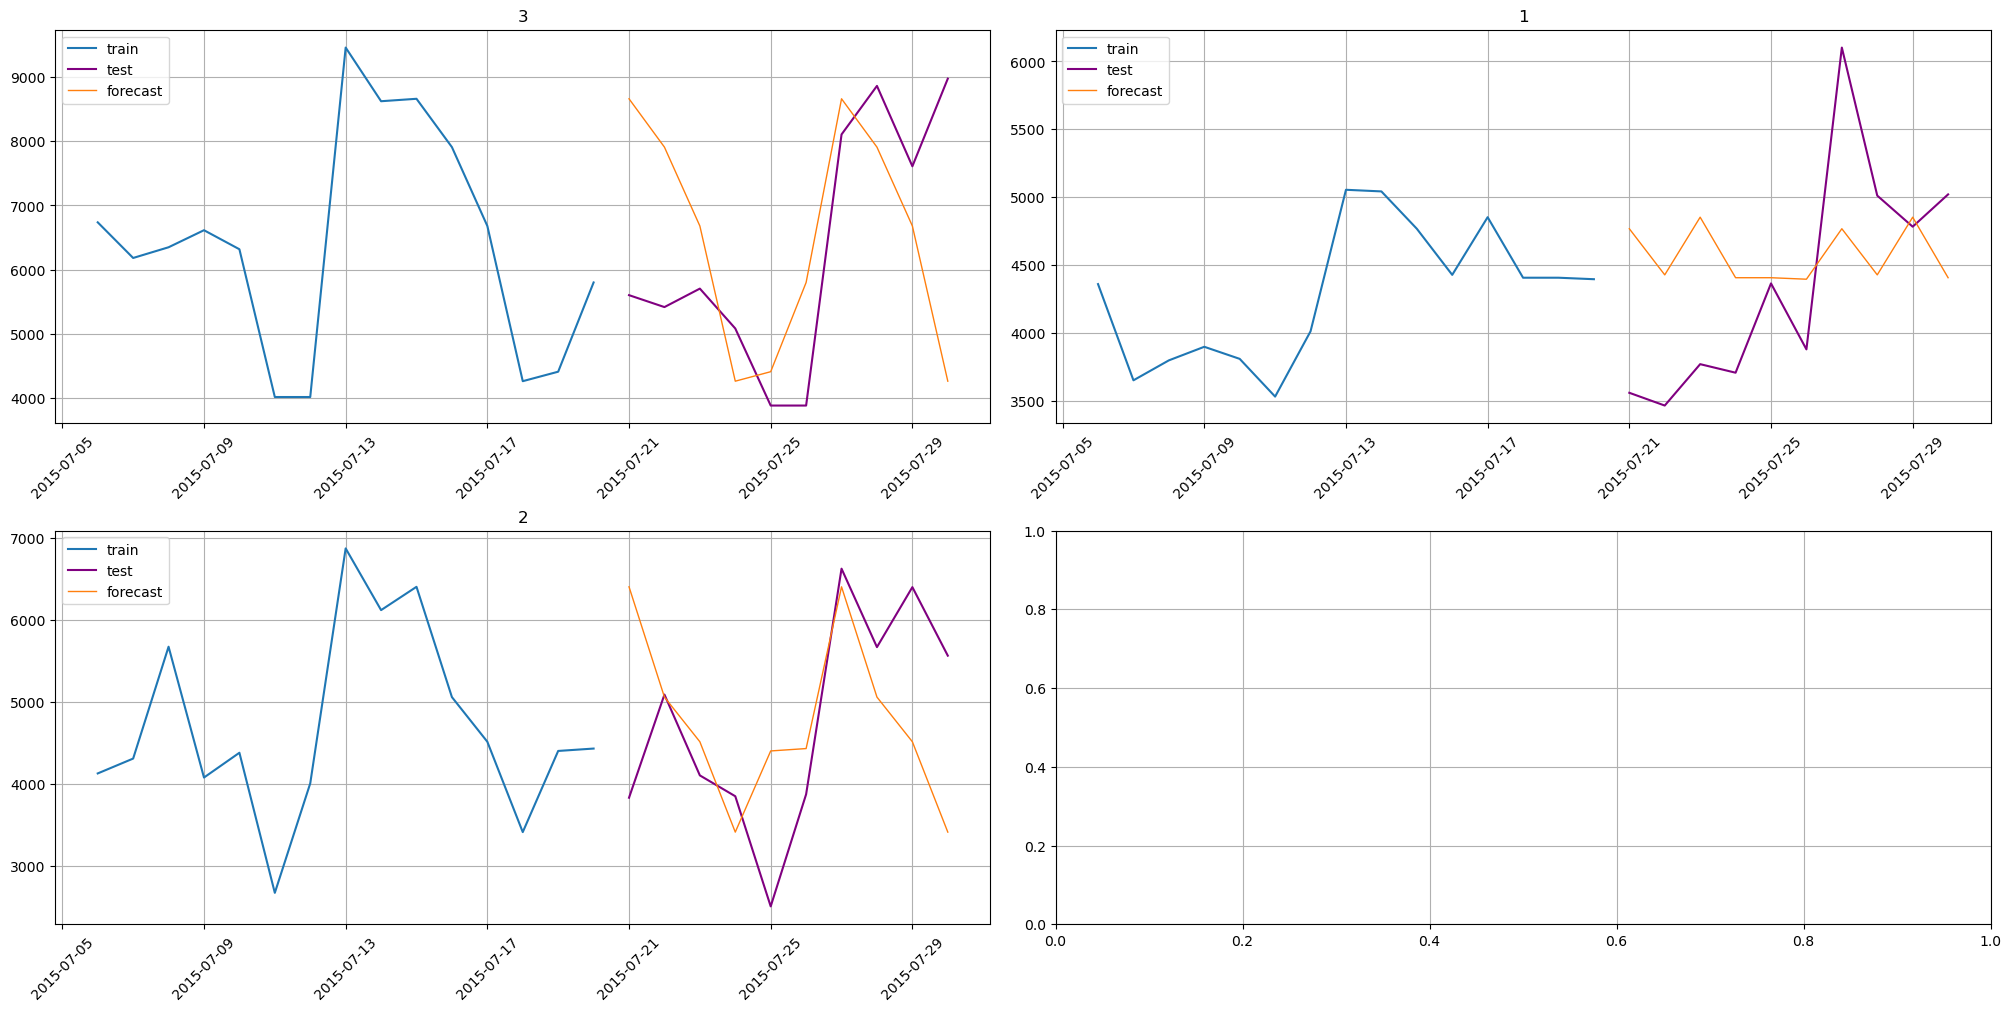

In [84]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=15)

In [89]:
model = MovingAverageModel(window=6)
model.fit(train_ts)

MovingAverageModel(window = 6, )

In [90]:
future_ts = train_ts.make_future(future_steps=horizon, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=horizon)

In [91]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'3': 25.786481920967887, '1': 16.2878999765155, '2': 24.493303649380916}

In [92]:
rmse = RMSE()
rmse(y_true=test_ts, y_pred=forecast_ts)

{'3': 1963.6226334804003, '1': 823.8481232078386, '2': 1317.2445924668718}

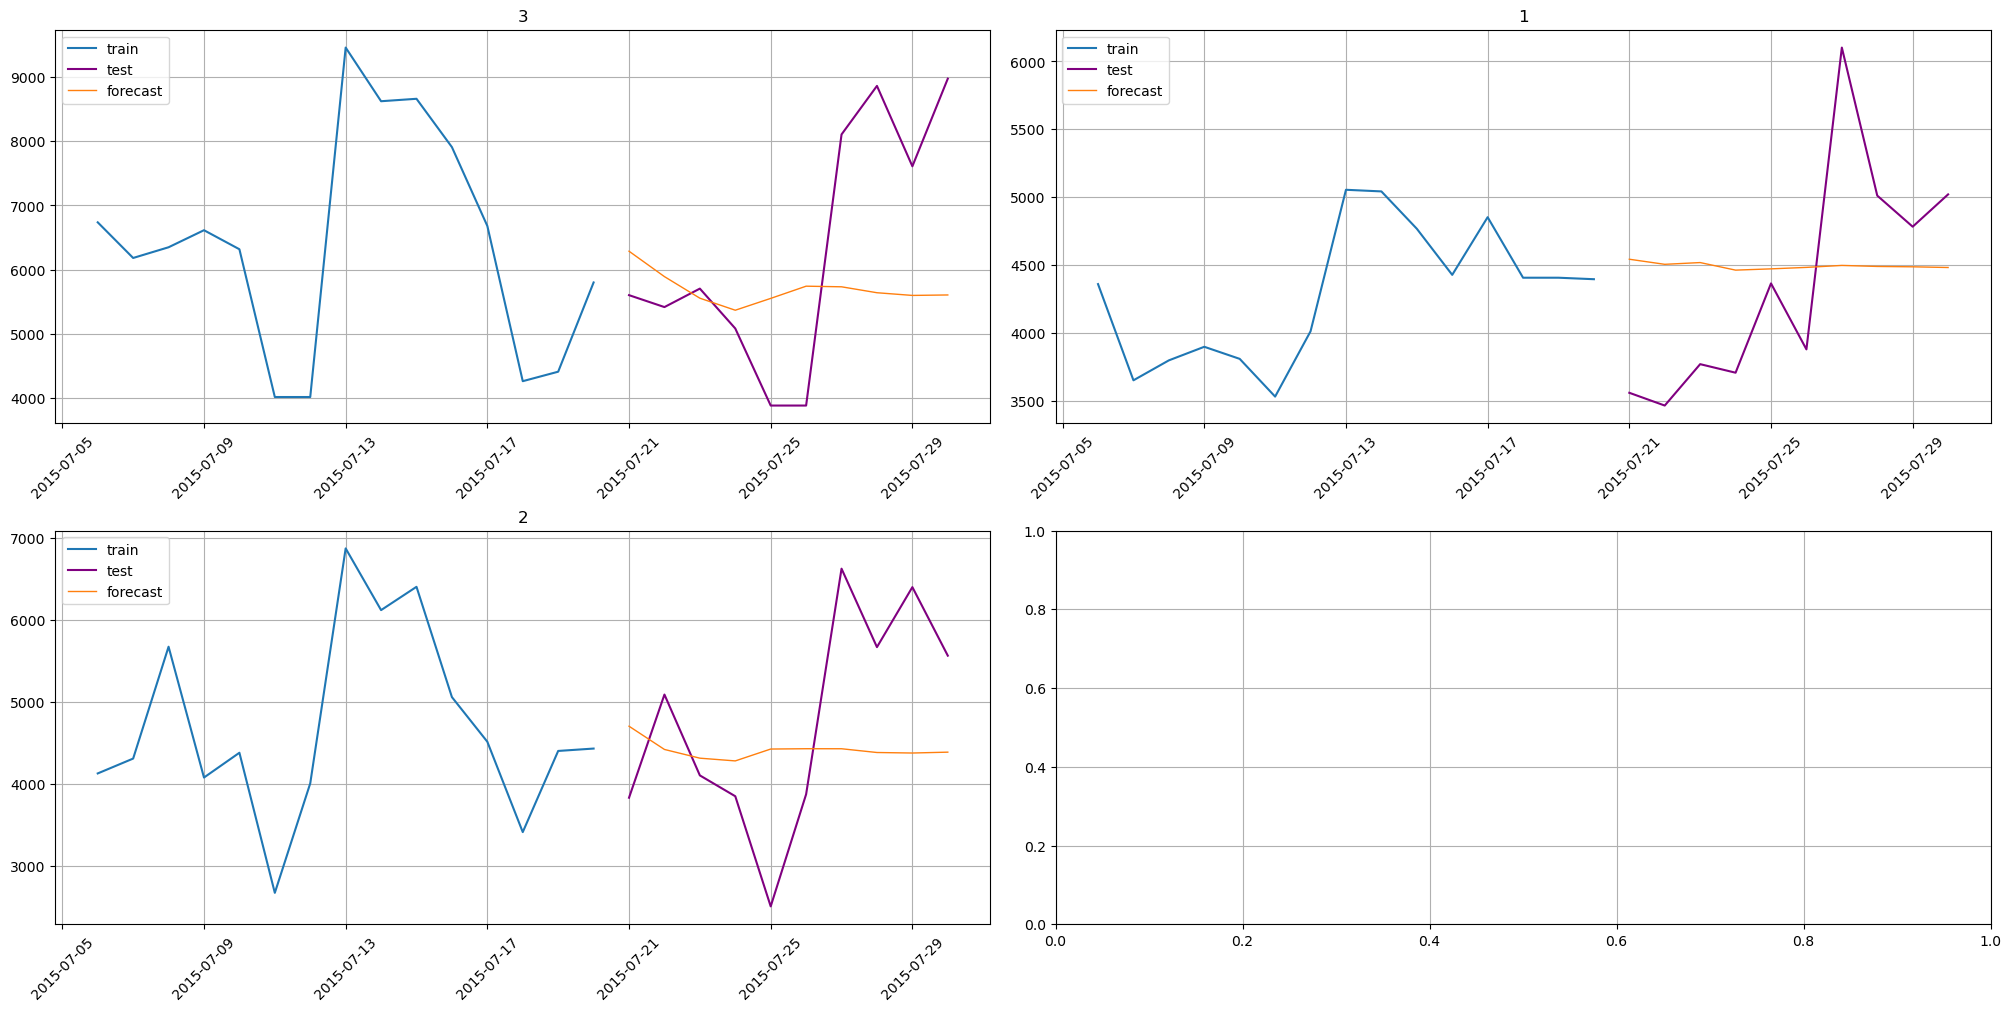

In [93]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=15)

In [114]:
model = SeasonalMovingAverageModel(window=9, seasonality=6).fit(train_ts)

In [115]:
future_ts = train_ts.make_future(future_steps=horizon, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=horizon)

In [116]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'3': 27.51890202826786, '1': 16.52175097847725, '2': 23.53504400833711}

In [117]:
rmse = RMSE()
rmse(y_true=test_ts, y_pred=forecast_ts)

{'3': 1933.2301232876941, '1': 816.4564953003822, '2': 1245.9909861146841}

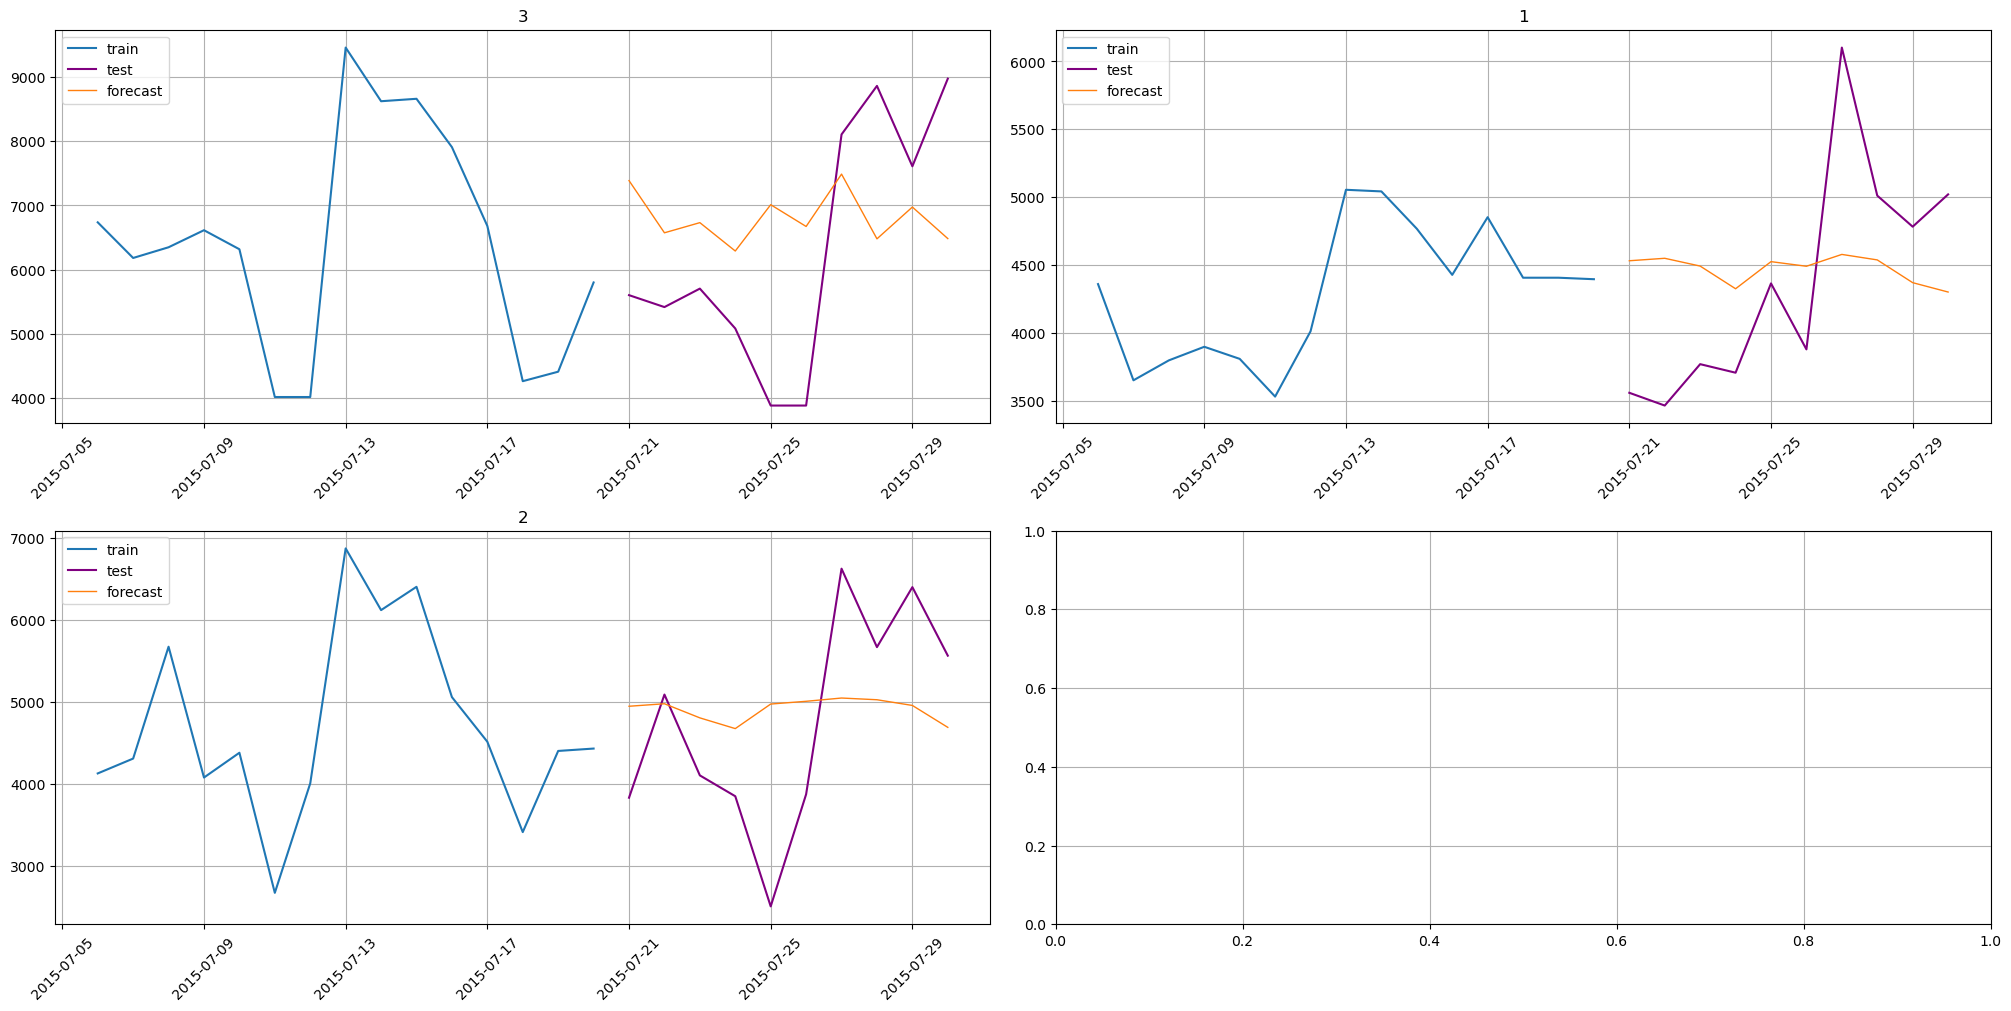

In [118]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=15)

In [120]:
df = pd.read_csv("Desktop/times/train.csv", parse_dates=["Date"], 
                 usecols=["Date", "Store", "Sales"], index_col="Date").sort_index()

In [182]:
df_sample = df[df["Store"] == 1].replace(0, np.nan).fillna(method="ffill").dropna()

In [184]:
result = adfuller(df_sample["Sales"])
print("ADF: ", result[0])
print("p-value: ", result[1])  # series is stationary, otherwise apply shift so many times until stationary. D, d params

ADF:  -5.768538246086614
p-value:  5.46038906195536e-07


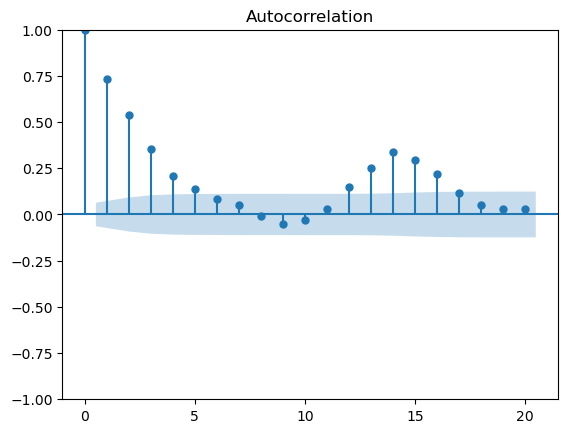

In [185]:
plot_acf(df_sample["Sales"], lags=20)
plt.show()

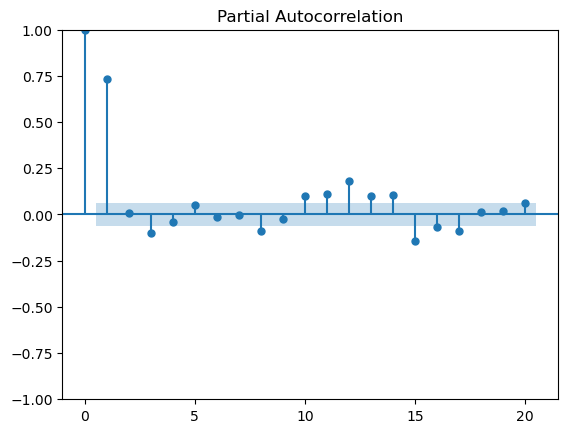

In [186]:
plot_pacf(df_sample["Sales"], lags=20)
plt.show()

In [223]:
model = SARIMAXModel(order=(1,0,0), seasonal_order=(1,0,0,6)).fit(train_ts)

In [224]:
future_ts = train_ts.make_future(future_steps=horizon, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts)

In [225]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'3': 26.476964258080933, '1': 16.301763775782547, '2': 23.892671863224976}

In [226]:
rmse = RMSE()
rmse(y_true=test_ts, y_pred=forecast_ts)

{'3': 1840.9165467387336, '1': 839.6861999138547, '2': 1251.6361096343414}

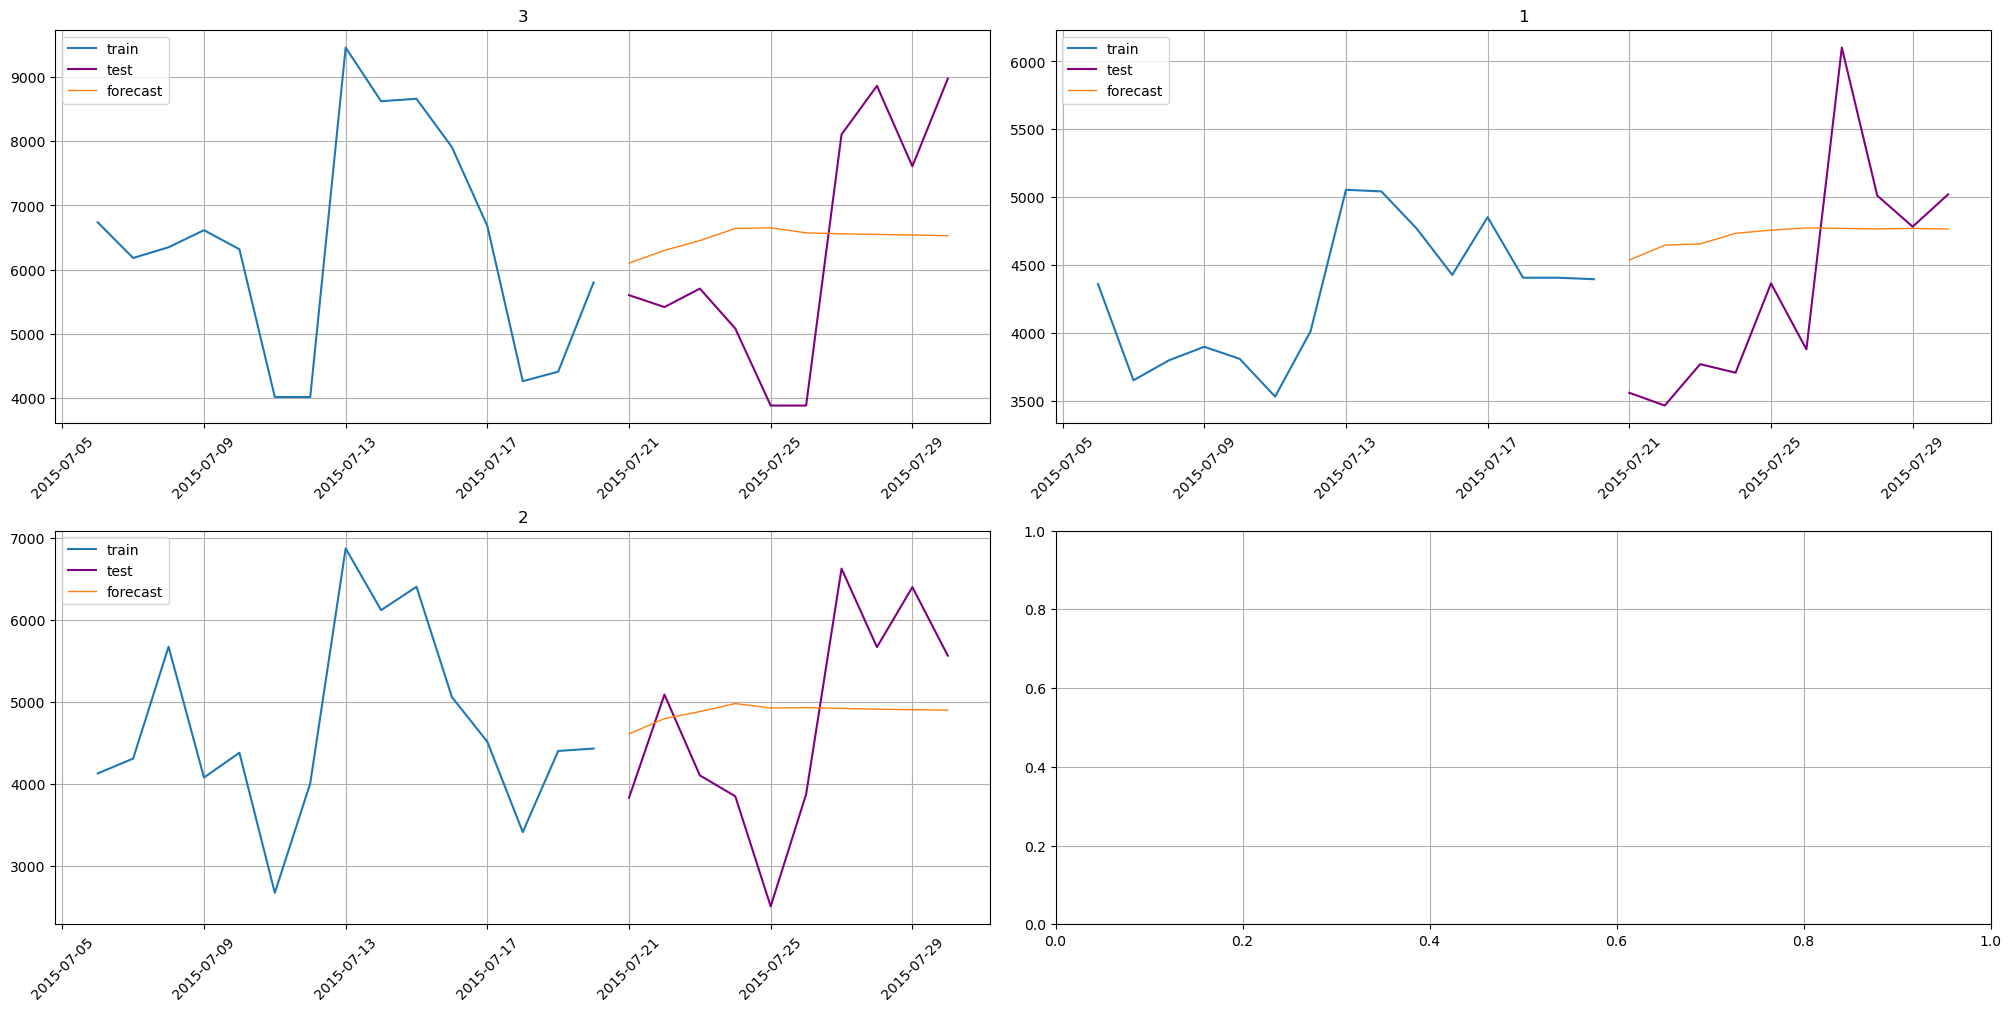

In [227]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=15)

In [248]:
model = HoltWintersModel(seasonal="additive", trend=None, seasonal_periods=6, smoothing_level=0.05, smoothing_trend=0, 
                        smoothing_seasonal=0.65).fit(train_ts)

In [249]:
future_ts = train_ts.make_future(future_steps=horizon, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts)

In [250]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'3': 30.262727147244156, '1': 16.911008206427624, '2': 28.244934681606644}

In [251]:
rmse = RMSE()
rmse(y_true=test_ts, y_pred=forecast_ts)

{'3': 2348.7912437687673, '1': 835.8008088741653, '2': 1561.4293857278744}

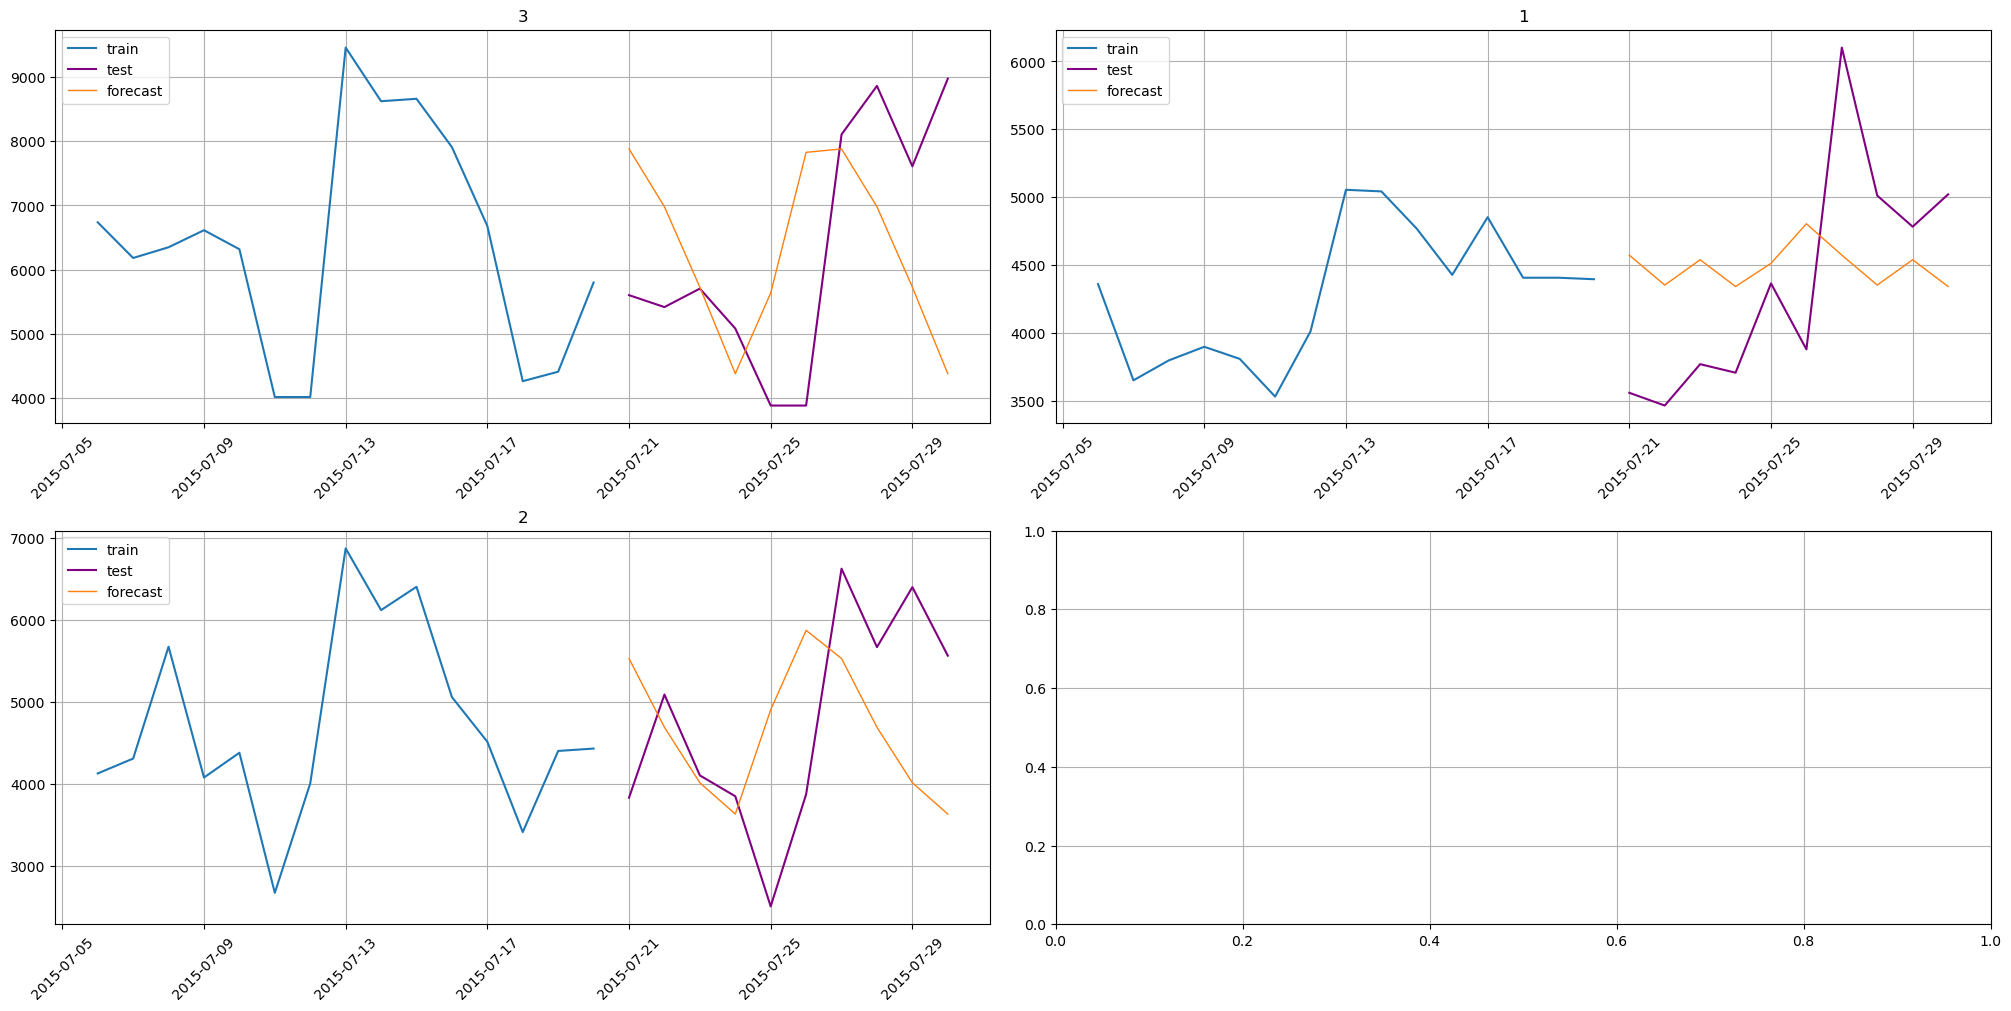

In [252]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=15)

In [283]:
mean7 = MeanTransform(in_column="target", window=7, out_column="mean7")
mean8 = MeanTransform(in_column="target", window=8, out_column="mean8")
mean9 = MeanTransform(in_column="target", window=9, out_column="mean9")
mean10 = MeanTransform(in_column="target", window=10, out_column="mean10")
mean11 = MeanTransform(in_column="target", window=11, out_column="mean11")

lags = LagTransform(in_column="target", lags=list(range(11,16,1)), out_column="lag")

In [284]:
model = CatBoostModelMultiSegment(loss_function="RMSE", n_estimators=800, learning_rate=0.05, depth=6, random_seed=42)

In [285]:
pipeline = Pipeline(model=model, transforms=[lags, mean7, mean8, mean9, mean10, mean11], horizon=horizon)
pipeline.fit(train_ts)

Pipeline(model = CatBoostModelMultiSegment(iterations = None, depth = 6, learning_rate = 0.05, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, loss_function = 'RMSE', n_estimators = 800, random_seed = 42, ), transforms = [LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 7, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean7', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', ), MeanTransform(in_column = 'target', window = 9, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean9', ), MeanTransform(in_column = 'target', window = 10, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean10', ), MeanTransform(in_column = 'target', window = 11, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean11', )], horizon = 10, )

In [286]:
forecast_ts = pipeline.forecast()

In [287]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'3': 33.21528157257182, '1': 18.341861622270194, '2': 18.19976862303978}

In [288]:
rmse = RMSE()
rmse(y_true=test_ts, y_pred=forecast_ts)

{'3': 2895.2614955987306, '1': 964.8138186959734, '2': 1027.019917361978}

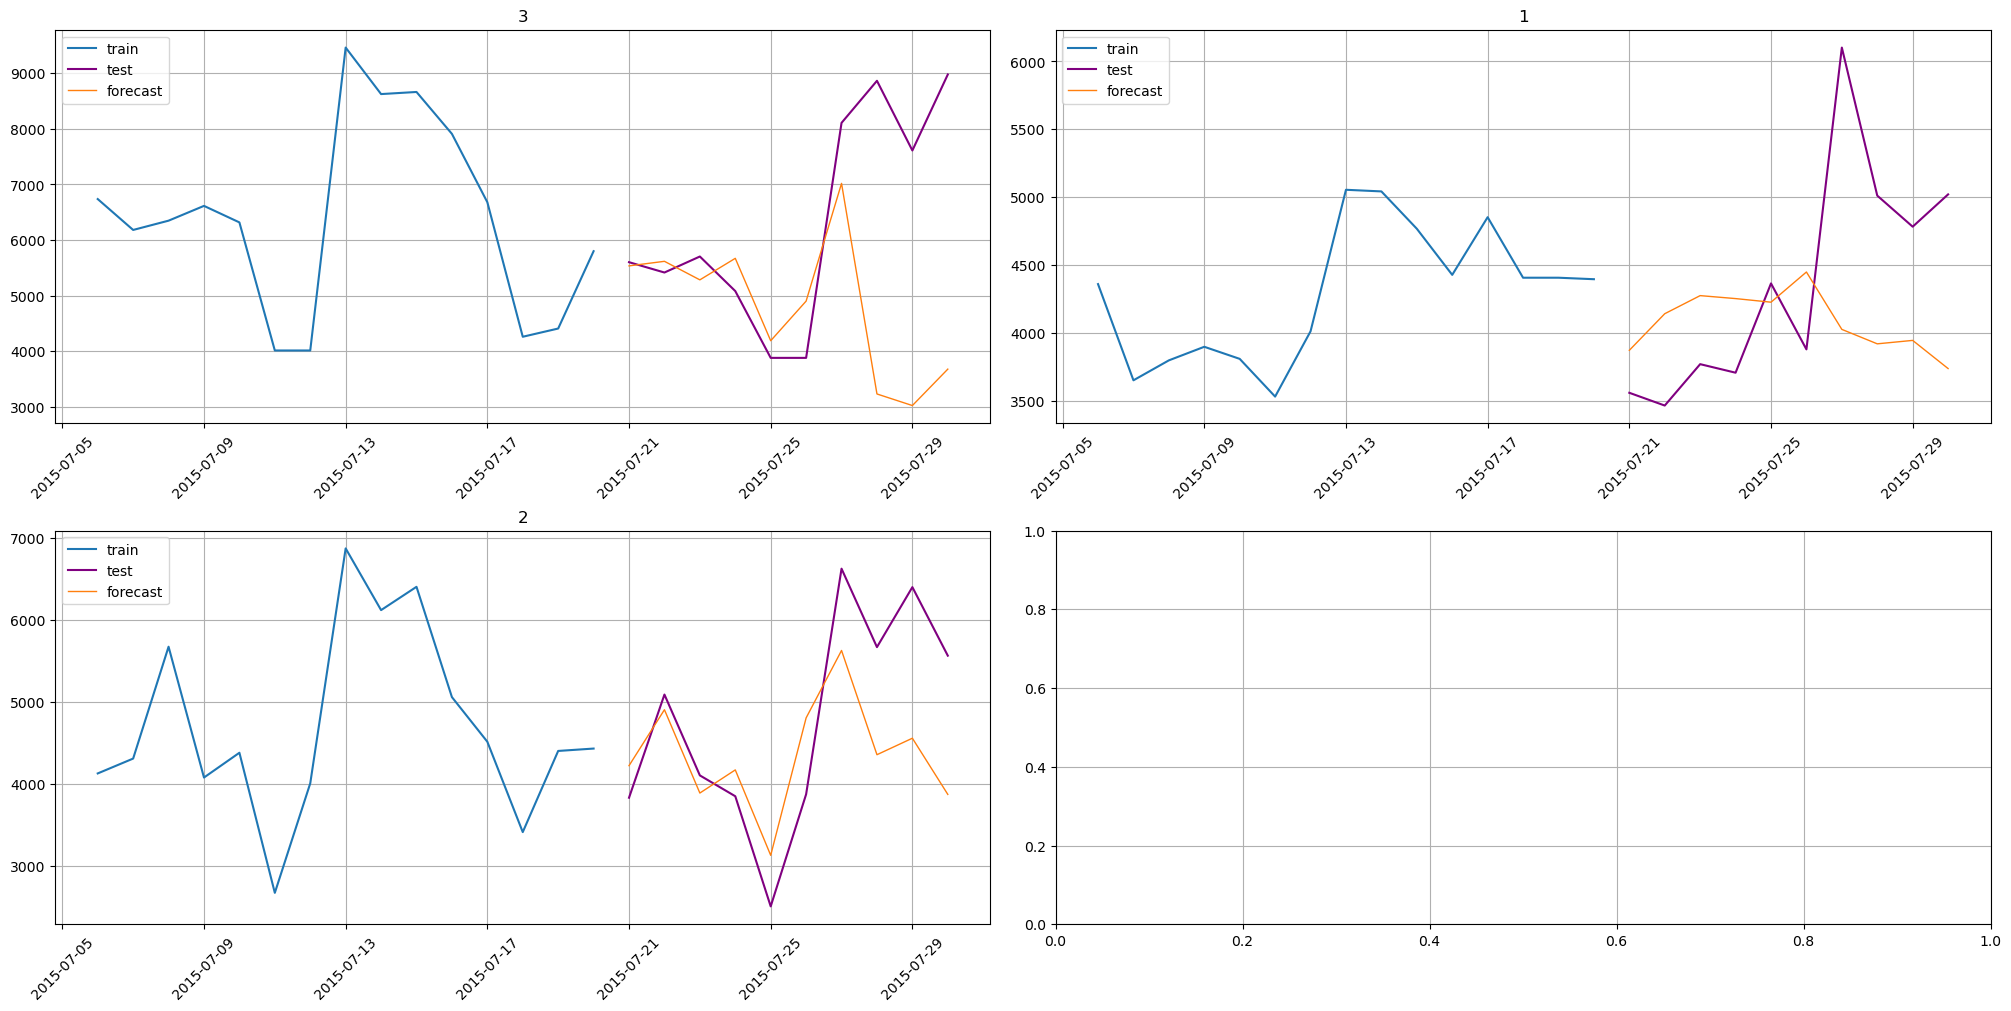

In [289]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=15)

In [290]:
elastic_transforms1 = [lags, mean8, StandardScalerTransform(in_column=None)]
elastic_transforms2 = [lags, mean8, MinMaxScalerTransform(in_column=None)]
elastic_transforms3 = [lags, mean8, RobustScalerTransform(in_column=None)]
elastic_transforms4 = [lags, mean8, MaxAbsScalerTransform(in_column=None)]

In [292]:
model = ElasticMultiSegmentModel(l1_ratio=0, alpha=0, random_state=42)

Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', ), StandardScalerTransform(in_column = None, inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', )]
SMAPE_mean: 13.859260048071958
SMAPE_std: 3.62869483783338
Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', ), MinMaxScalerTransform(in_column = None, inplace = True, out_column = None, feature_range = (0, 1), clip = True, mode = 'per-segment', )]
SMAPE_mean: 13.898478667613341
SMAPE_std: 3.380458226204374
Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, se

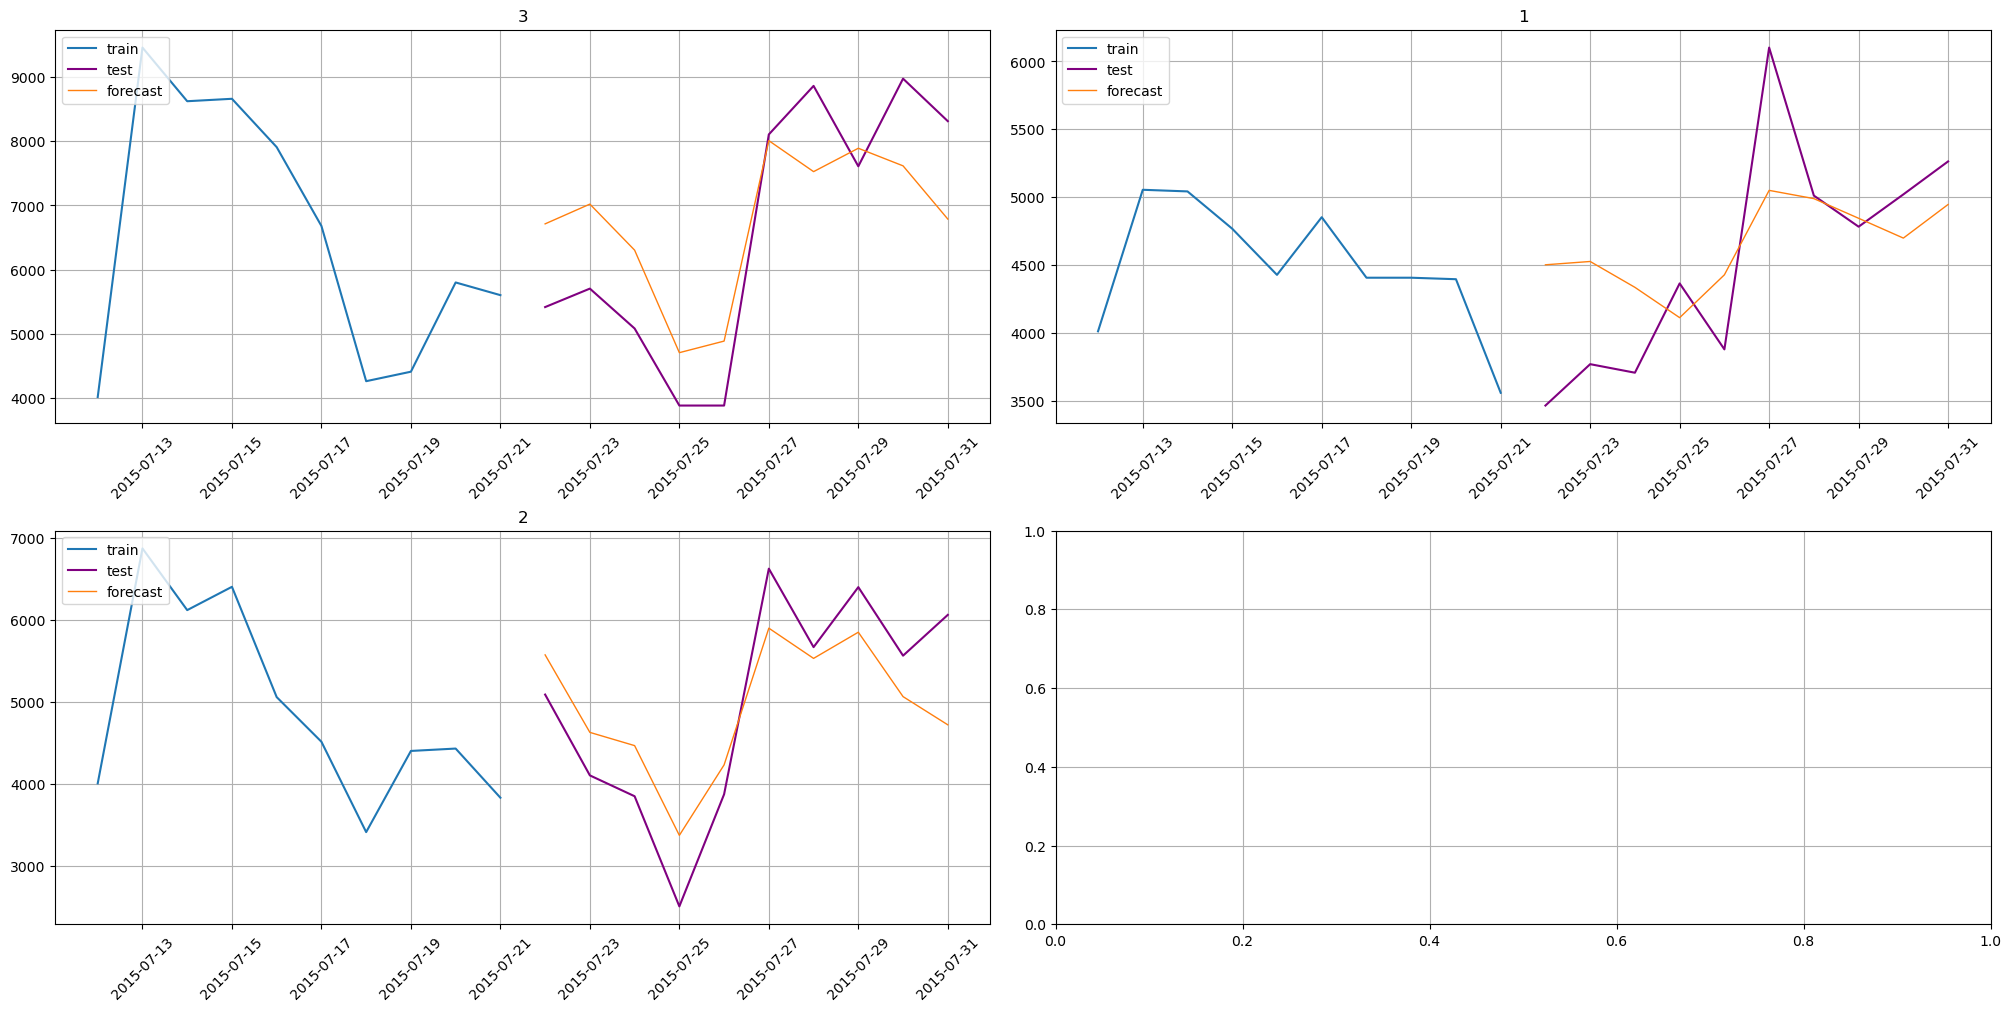

In [300]:
etna_cv_optimize(ts=ts, model=model, horizon=horizon, transforms=[elastic_transforms1, elastic_transforms2, 
                                                                  elastic_transforms3, elastic_transforms4],
                n_folds=5, mode="expand", metrics=SMAPE(), refit=True)

In [301]:
model = CatBoostModelMultiSegment(loss_function="RMSE", n_estimators=800, learning_rate=0.05, depth=6, random_seed=42)

Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', )]
SMAPE_mean: 18.175638773081623
SMAPE_std: 7.947944386104901
Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', ), MeanTransform(in_column = 'target', window = 9, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean9', ), MeanTransform(in_column = 'target', window = 10, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean10', ), MeanTransform(in_column = 'target', window = 11, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean11', )]
SMAPE_mean: 19.660958798328867
SMAPE_std: 9.13458343671067
Transform:
[MeanTransform(in_

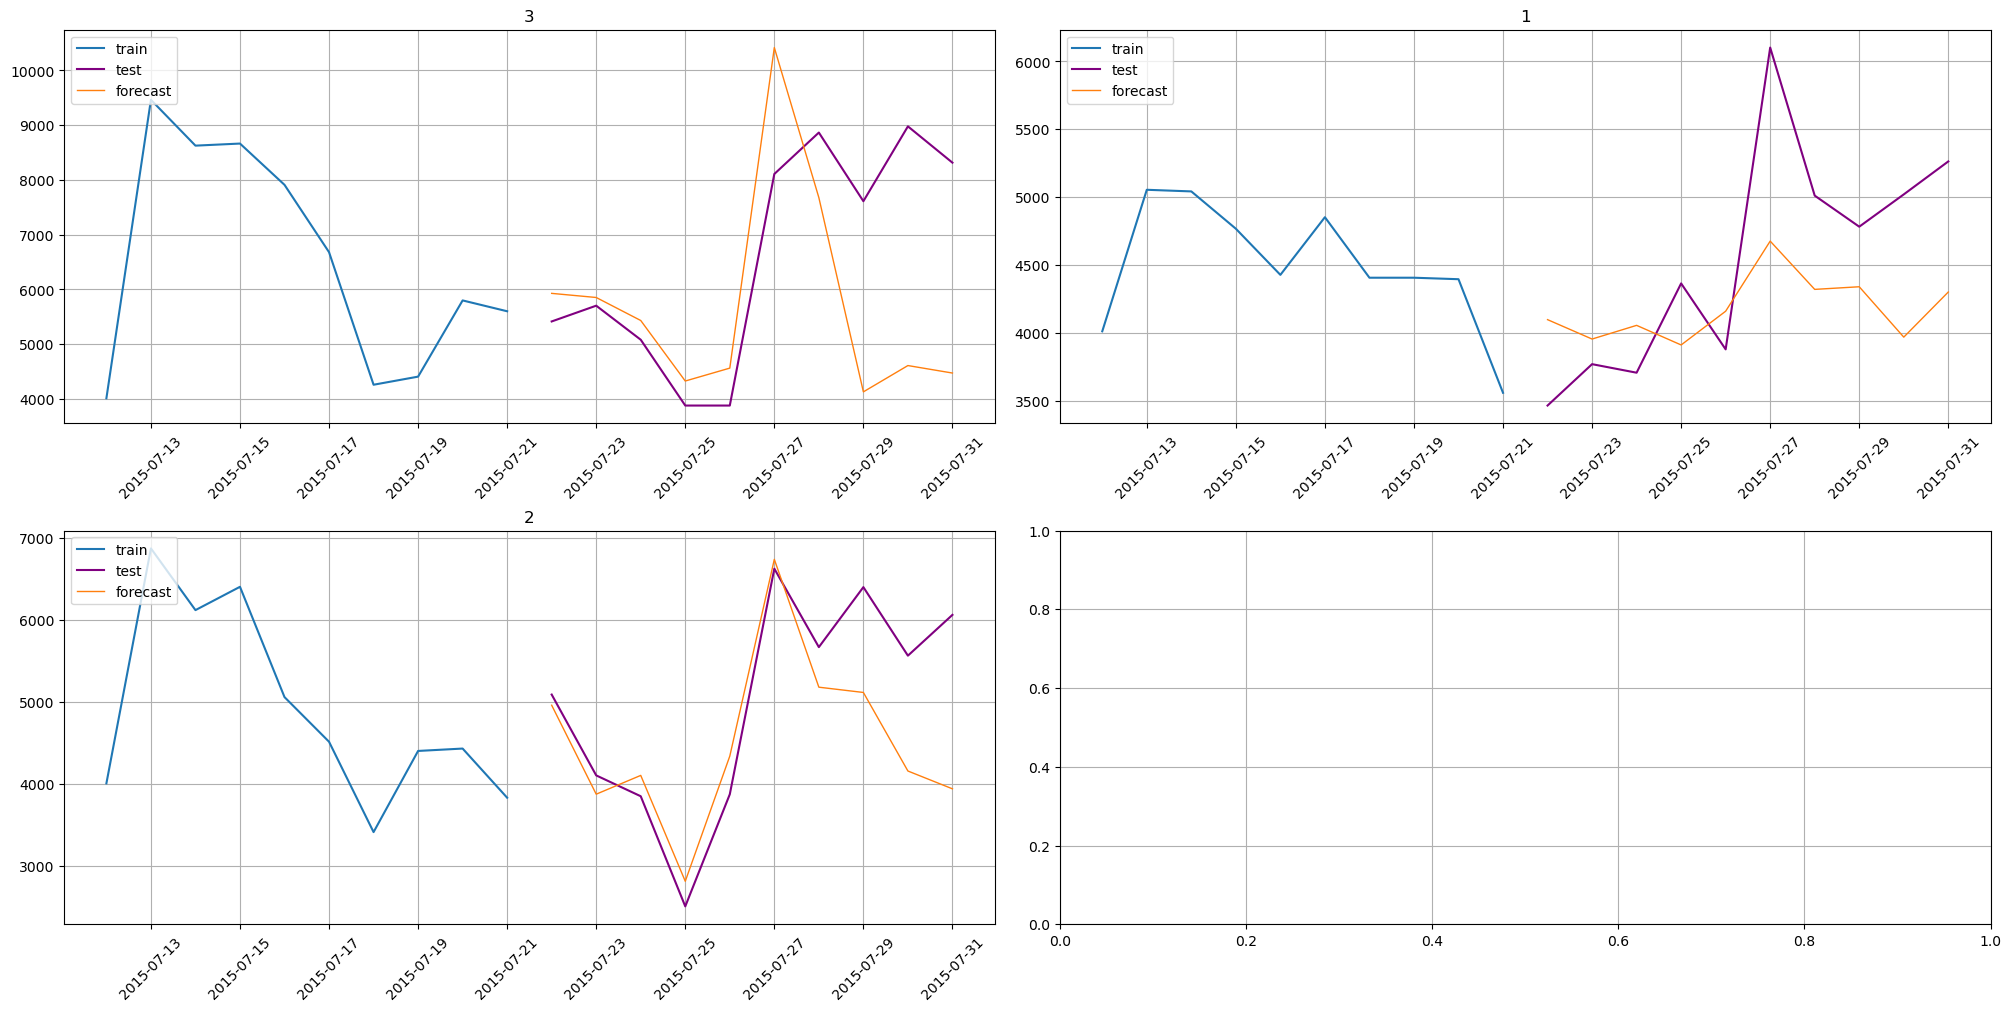

In [302]:
etna_cv_optimize(ts=ts, model=model, horizon=horizon, transforms=[[lags, mean8], 
                                                                  [lags, mean8, mean9, mean10, mean11],
                                                                  [mean8, mean9, mean10, mean11]],
                n_folds=5, mode="expand", metrics=SMAPE(), refit=True)

In [303]:
ts = read_ts("Desktop/times/train.csv", "Date", usecols=["Sales", "Store", "Date"], low_memory=False, melt_df=True, sample=1)

In [305]:
horizon = 10

train_ts, test_ts = ts.train_test_split(train_start='2013-01-02', 
                                        train_end='2015-07-20',
                                        test_size=horizon)

In [306]:
model = CatBoostModelMultiSegment(loss_function="RMSE", n_estimators=800, learning_rate=0.05, depth=6, random_seed=42)

Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', )]
SMAPE_mean: 11.434039432793627
SMAPE_std: 4.185175047324606
Transform:
[LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean8', ), MeanTransform(in_column = 'target', window = 9, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean9', ), MeanTransform(in_column = 'target', window = 10, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean10', ), MeanTransform(in_column = 'target', window = 11, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean11', )]
SMAPE_mean: 13.375661712133901
SMAPE_std: 5.026207743861215
Transform:
[MeanTransform(in

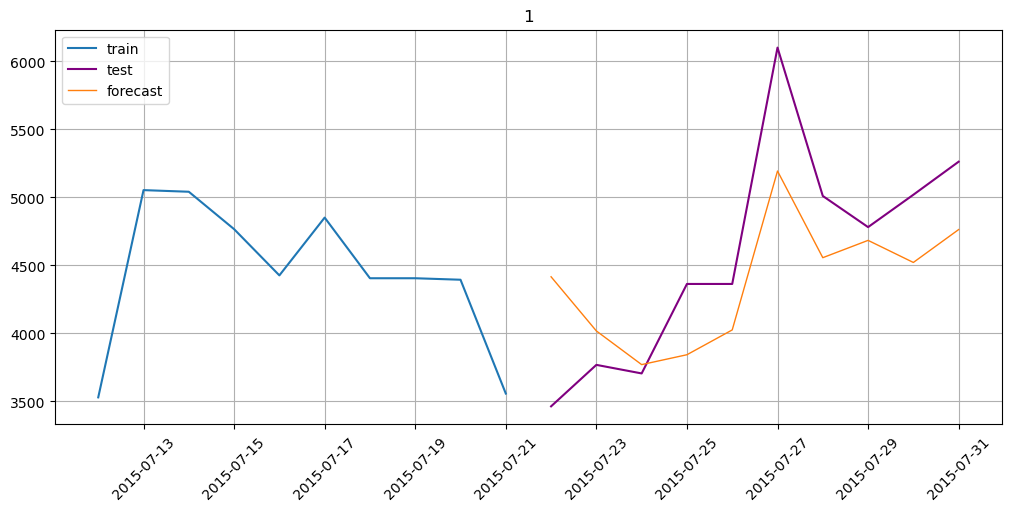

In [307]:
etna_cv_optimize(ts=ts, model=model, horizon=horizon, transforms=[[lags, mean8], 
                                                                  [lags, mean8, mean9, mean10, mean11],
                                                                  [mean8, mean9, mean10, mean11]],
                n_folds=5, mode="expand", metrics=SMAPE(), refit=True)

In [320]:
df_sample = df.loc[df["Store"] == 1, ["Sales"]].reset_index().rename(columns={"Date": "timestamp"})
df_sample.replace(0, np.nan, inplace=True)
df_sample = df_sample.melt(id_vars="timestamp", var_name="segment", value_name="target")

In [323]:
df_sample = TSDataset.to_dataset(df_sample)

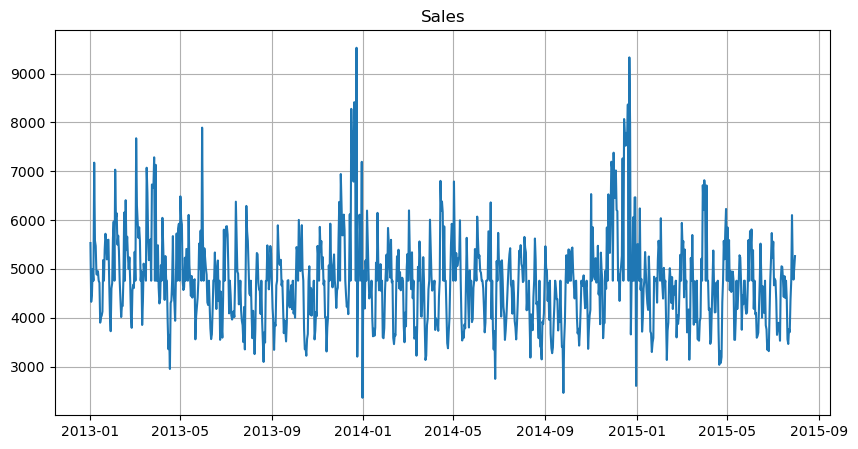

In [326]:
df_sample = etna_impute(df_sample)

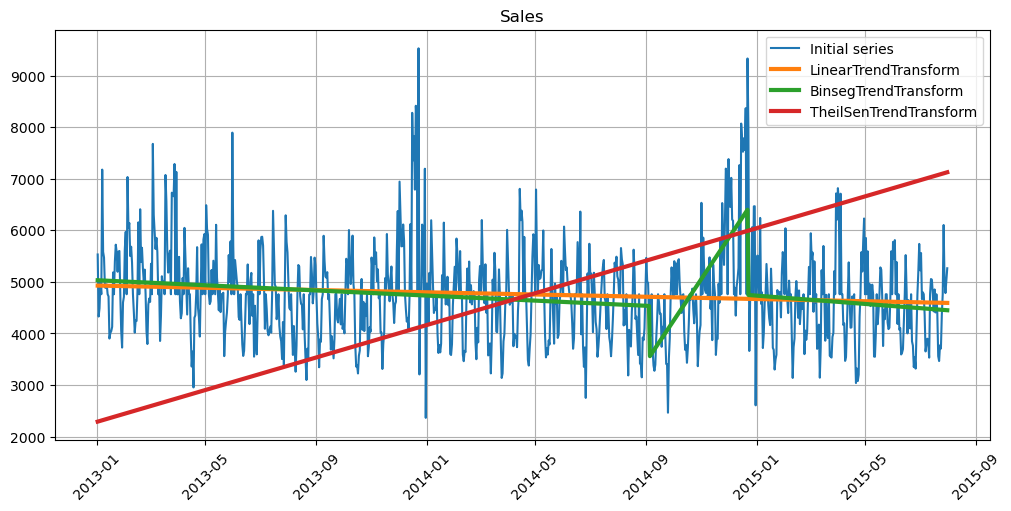

In [327]:
plot_trend(ts=df_sample, trend_transform=[LinearTrendTransform(in_column="target"),
                                          BinsegTrendTransform(in_column="target", n_bkps=2, min_size=100),
                                          TheilSenTrendTransform(in_column="target")])

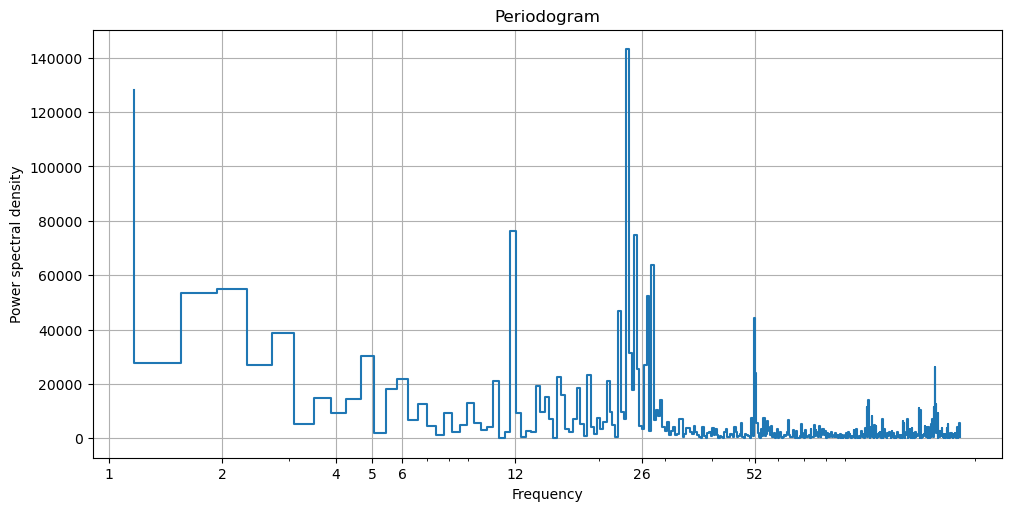

In [340]:
plot_periodogram(df_sample, period=365.24, xticks=[1,2,4,5,6,12,26,52])

In [341]:
train_ts, test_ts = df_sample.train_test_split(test_size=horizon)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

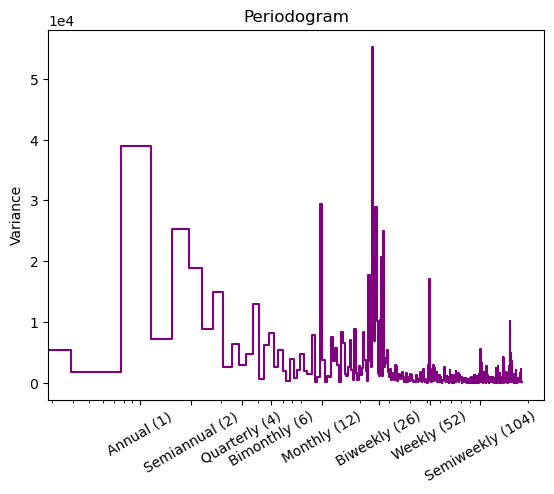

In [357]:
plot_periodogram(pd.Series(df_sample.to_pandas().fillna(method="ffill").dropna().loc[:, pd.IndexSlice[:, "target"]].values.flatten()))

In [416]:
model = CatBoostModelPerSegment(loss_function="RMSE", n_estimators=800, learning_rate=0.05, depth=6, random_seed=42)

In [385]:
# read and replace 0 with nans
ts = read_ts("Desktop/times/train.csv", "Date", 
             usecols=["Sales", "Store", "Date"], low_memory=False, melt_df=True, sample=1, fillna=False)

In [417]:
outlier_remover = MedianOutliersTransform(in_column="target", window_size=150, alpha=15)
outlier_imputer = TimeSeriesImputerTransform(in_column="target", strategy="forward_fill")

log = LogTransform(in_column="target")  # log target variable; apply exp during evaluation
detrend = LinearTrendTransform(in_column="target")  # compute linear trend and divides it from target
lags = LagTransform(in_column="target", lags=list(range(11,16,1)), out_column="lag")

# moving averages
mean5 = MeanTransform(in_column="target", window=5, out_column="mean5")
mean6 = MeanTransform(in_column="target", window=6, out_column="mean6")
mean7 = MeanTransform(in_column="target", window=7, out_column="mean7")
mean8 = MeanTransform(in_column="target", window=8, out_column="mean8")
mean9 = MeanTransform(in_column="target", window=9, out_column="mean9")
mean10 = MeanTransform(in_column="target", window=10, out_column="mean10")
mean11 = MeanTransform(in_column="target", window=11, out_column="mean11")

# add trend as feature
trend_feature = TrendTransform(in_column="target")

# date features
d_flags = DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, 
                             month_number_in_year=True, is_weekend=True, out_column="dt")
holidays = HolidayTransform(iso_code="US", out_column="EN_holiday")

# fourier series features for year and biweekly seasonality
fourier_year = FourierTransform(period=365.2425, order=3, out_column="fourier_year")
fourier_biweek = FourierTransform(period=24, order=2, out_column="fourier_biweek")

transforms = [outlier_remover, outlier_imputer, log, detrend, trend_feature, lags, mean5, mean6, mean7, mean8, 
              mean9, mean10, mean11, d_flags, holidays, fourier_year, fourier_biweek]

Sales    7.754783 

Mean metric: 7.754782528397508


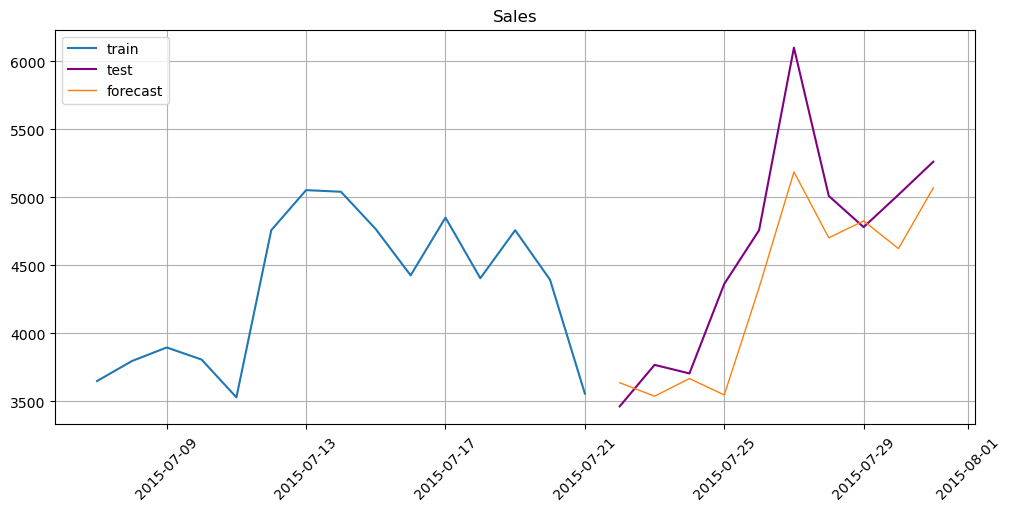

In [403]:
train_and_evaluate(df_sample, model, transforms, horizon, SMAPE(), n_train_samples=15)

Transforms:
[MedianOutliersTransform(in_column = 'target', window_size = 150, alpha = 15, ), TimeSeriesImputerTransform(in_column = 'target', strategy = 'forward_fill', window = -1, seasonality = 1, default_value = None, constant_value = 0, ), LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), TrendTransform(in_column = 'target', out_column = None, detrend_model = LinearRegression(), model = 'ar', custom_cost = None, min_size = 2, jump = 1, n_bkps = 5, pen = None, epsilon = None, )]
SMAPE_mean: 15.063859633044123
SMAPE_std: 5.17906503755898
Transforms:
[MedianOutliersTransform(in_column = 'target', window_size = 150, alpha = 15, ), TimeSeriesImputerTransform(in_column = 'target', strategy = 'forward_fill', window = -1, seasonality = 1, default_value = None, constant_value = 0, ), LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), LinearTrendTransform(in_colum

Transforms:
[MedianOutliersTransform(in_column = 'target', window_size = 150, alpha = 15, ), TimeSeriesImputerTransform(in_column = 'target', strategy = 'forward_fill', window = -1, seasonality = 1, default_value = None, constant_value = 0, ), LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), TrendTransform(in_column = 'target', out_column = None, detrend_model = LinearRegression(), model = 'ar', custom_cost = None, min_size = 2, jump = 1, n_bkps = 5, pen = None, epsilon = None, ), LagTransform(in_column = 'target', lags = [11, 12, 13, 14, 15], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 5, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean5', ), MeanTransform(in_column = 'target', window = 6, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean6', ), MeanTransform(in_column = 'target', window = 7, seasonality = 1, alph

{'Sales': 7.887092823560063}


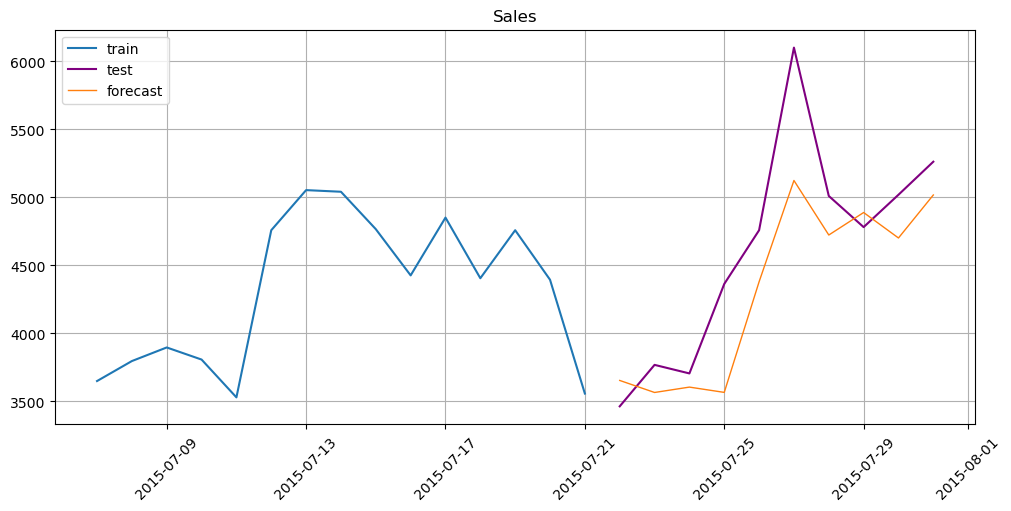

In [430]:
# etna select best transforms
etna_staged_cv_optimize(ts=df_sample, model=model, horizon=horizon, init_transforms=[outlier_remover, outlier_imputer, 
                                                                                     log, detrend],
                        transforms=[trend_feature, lags, mean5, mean6, mean7, mean8, 
                                    mean9, mean10, mean11, d_flags, holidays, fourier_year, fourier_biweek],
                        n_folds=10, mode="expand", metrics=SMAPE(), refit=True)

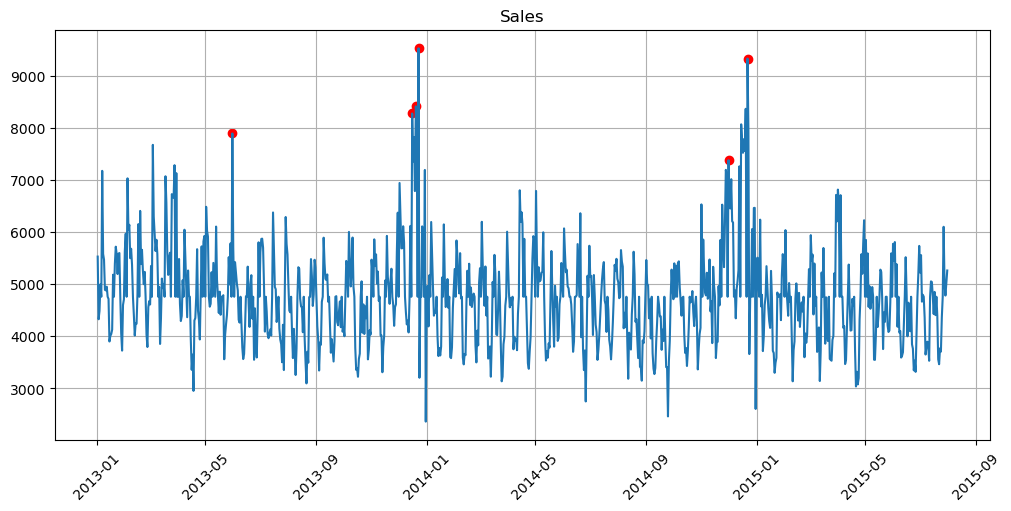

In [365]:
# strategy: replace by nan and search optimal imputation method, e.g. MedianOutlierTransform -> etna_impute(...)
anomaly_dict = get_anomalies_median(df_sample, window_size=100)
plot_anomalies(df_sample, anomaly_dict)

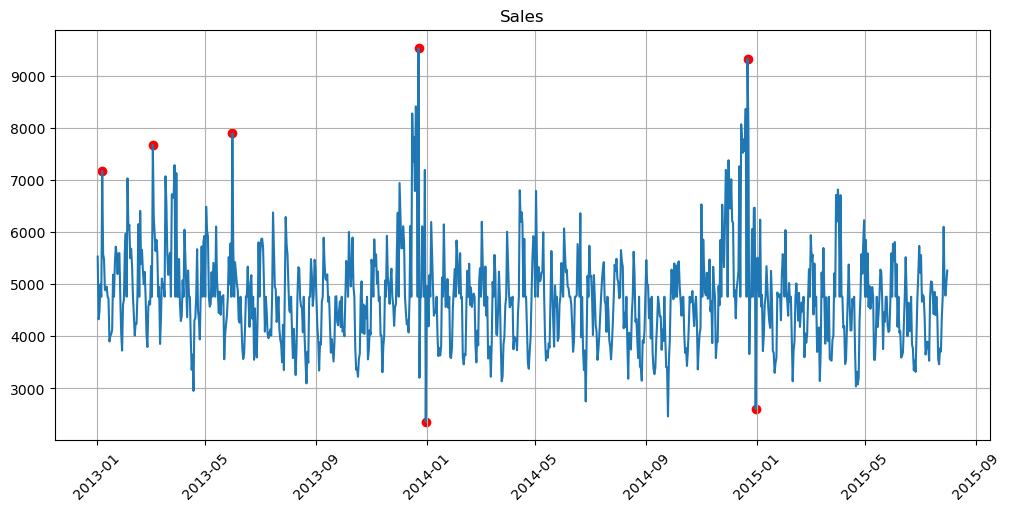

In [374]:
anomaly_dict = get_anomalies_density(df_sample, window_size=20, distance_coef=1.5, n_neighbors=4)
plot_anomalies(df_sample, anomaly_dict)

In [ ]:
anomaly_dict = get_anomalies_hist(df_sample, bins_number=10)
plot_anomalies(df_sample, anomaly_dict)

In [376]:
params_bounds = {"window_size": (40, 120, 1),
                 "alpha": (0.1, 4, 0.25)}
plot_anomalies_interactive(ts=df_sample, segment="Sales", method=get_anomalies_median, params_bounds=params_bounds)

interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', max=120, min=40,…